base:
  'N': 10
  T: 11000
  T_train_val: 10000
  train_ratio: 0.8
  T_train: 8000
  T_val: 2000
  T_test: 1000
data_generation:
  load_data:
    node_mean: 50.0
    node_var: 10.0
    node_iid_var: 5.0
    node_theta: 0.9
  latency:
    mean: 0.0
    var: 0.0
    iid_var: 0.0
    theta: 0.0
exp4:
  batch_size: 64
  seq_length: 20
  input_size: 10
  output_size: 10
  learning_rate: 0.001
  num_workers: 24
  num_epochs: 100
  device: cuda
  mix_precision: true
  patience_epochs: 6
  min_delta: 0.001
  mode: min
  factor: 0.1
  patience_lr: 2
  min_lr: 1.0e-06
  threshold: 0.01
  ARconfig:
    order: 5
  LSTMCconfig:
    hidden_size: 128
    num_layers: 4
  GNNconfig:
    hidden_size: 128
    num_layers: 4



/usr/local/Anaconda3/envs/MScProject/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


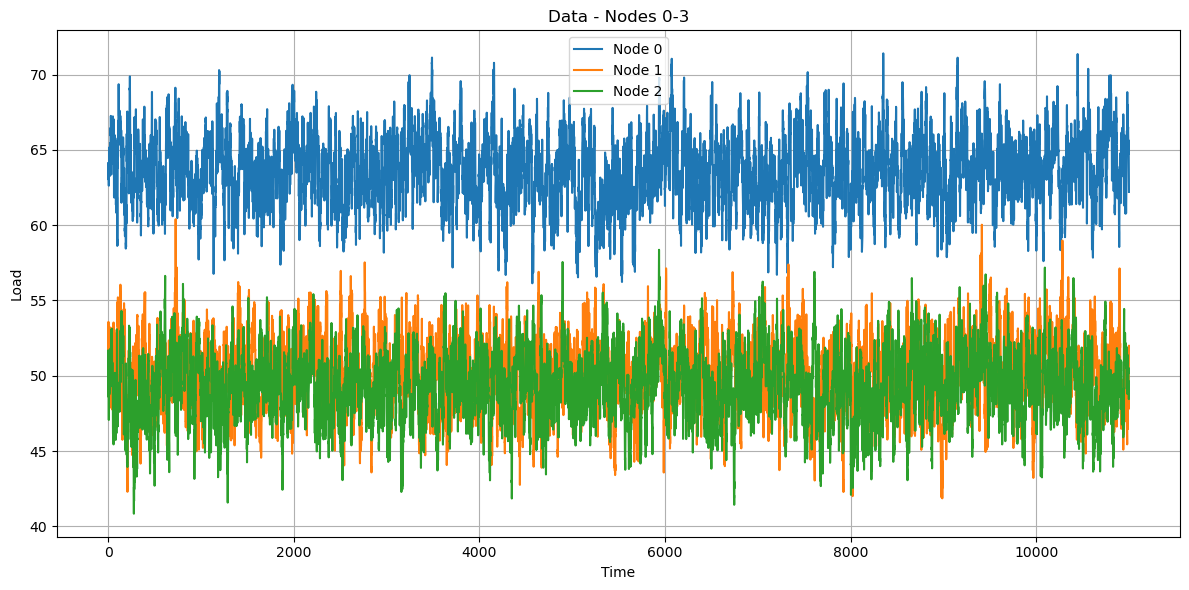

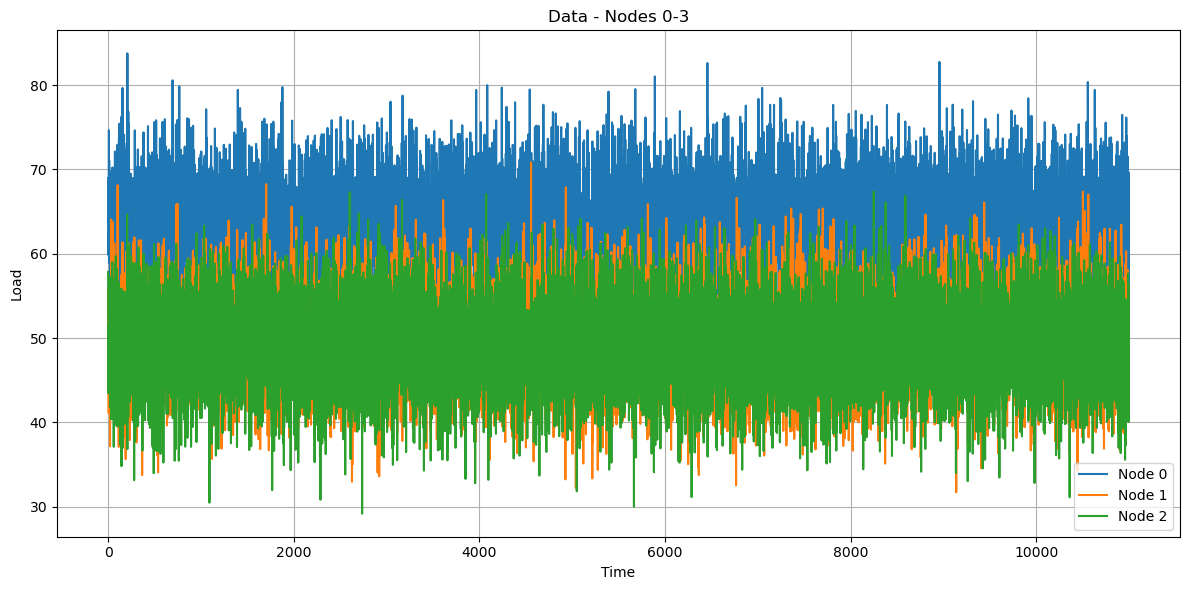

In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import pickle
from omegaconf import DictConfig, OmegaConf

# 将 MScProject 目录添加到 Python 模块搜索路径
sys.path.append(os.path.abspath('..'))
# 从 DataGenerate.py 导入 DataGenerate 类 用于pickle导入
from DataGenerate import TrainValidManage

# 加载 config.yaml 文件
main_config = OmegaConf.load("../config/config.yaml")

# 打印完整的配置内容
print(OmegaConf.to_yaml(main_config))
# # 明确添加安全的全局对象, 用于防止导入pickle时的警告信息
# torch.serialization.add_safe_globals({"TrainValidManage": TrainValidManage})

# 从文件加载对象
with open('../Data/ar1_data_train_val_manage.pkl', 'rb') as f:
    ar1_data_train_val_manage = pickle.load(f)

# 从文件加载对象
with open('../Data/iid_data_train_val_manage.pkl', 'rb') as f:
    iid_data_train_val_manage = pickle.load(f)
ar1_data_train_val_manage.plot_range_data(ar1_data_train_val_manage.data_np[:3, :], title='Data')
iid_data_train_val_manage.plot_range_data(iid_data_train_val_manage.data_np[:3, :], title='Data')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class GNNTimeSeriesPredictor:
    def __init__(self, data, T_train, batch_size=32, seq_length=20, input_size=10, output_size=10, learning_rate=0.001):
        self.data = data
        self.T_train = T_train
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.input_size = input_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Prepare the dataset
        self.train_data = torch.tensor(data[:, :T_train], dtype=torch.float32)
        self.test_data = torch.tensor(data[:, T_train:], dtype=torch.float32)

        sequences, targets = self.create_sequences(self.train_data, self.seq_length, self.T_train)
        self.train_dataset = TensorDataset(sequences, targets)
        self.dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

        # Create the model
        self.model = GNNModel(in_channels=self.input_size, out_channels=self.output_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

        # Assume a fully connected graph structure
        self.edge_index = torch.tensor(np.array([(i, j) for i in range(self.input_size) for j in range(self.input_size)]).T, dtype=torch.long)

    def create_sequences(self, data, seq_length, T_train):
        sequences = []
        targets = []
        for i in range(T_train - seq_length):
            seq = data[:, i: i + seq_length].T
            target = data[:, i + seq_length]
            sequences.append(seq)
            targets.append(target)
        return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(np.array(targets), dtype=torch.float32)

    def train(self, num_epochs=100):
        self.model.train()
        for epoch in tqdm(range(num_epochs), desc="Training"):
            for inputs, targets in self.dataloader:
                outputs = self.model(inputs, self.edge_index)
                loss = self.criterion(outputs, targets)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

    def test(self, T_test):
        total_loss = 0
        predictions = []
        true_values = []
        x_test = self.train_data[:, -self.seq_length:].T.unsqueeze(0)

        self.model.train()
        for i in range(T_test):
            pred = self.model(x_test, self.edge_index)
            real_value = self.test_data[:, i]

            predictions.append(pred.squeeze(0).detach().cpu().numpy())
            true_values.append(real_value.detach().cpu().numpy())

            loss = self.criterion(pred.squeeze(0), real_value)
            total_loss += loss.item()
            print(f'Step [{i + 1}/{T_test}], Loss: {loss.item():.4f}')

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            x_test = torch.cat((x_test[:, 1:, :], real_value.unsqueeze(0).unsqueeze(0)), dim=1)

        avg_loss = total_loss / T_test
        print(f'Average Loss over {T_test} steps: {avg_loss:.4f}')

        return np.array(predictions), np.array(true_values)

    def plot_predictions(self, predictions, true_values):
        plt.figure(figsize=(12, 6))
        plt.plot(predictions[:, 0], label='Predicted')
        plt.plot(true_values[:, 0], label='True')
        plt.xlabel('Time Steps')
        plt.ylabel('Load Value')
        plt.title('Predicted vs True Load Values for Node 1')
        plt.legend()
        plt.show()


class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)
        self.rnn = torch.nn.GRU(out_channels, out_channels, batch_first=True)
        self.fc = torch.nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        batch_size, seq_len, num_nodes = x.size()

        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)

        out, _ = self.rnn(x)

        out = self.fc(out[:, -1, :])
        return out

# Example usage:
# predictor = GNNTimeSeriesPredictor(data=load_ar1, T_train=1000)
# predictor.train(num_epochs=100)
# predictions, true_values = predictor.test(T_test=1000)
# predictor.plot_predictions(predictions, true_values)


In [ ]:
# 假设你已经准备好了 load_ar1, T_train, 和 T_test
data = load_ar1
T_train = 10000
T_test = 1000

# 1. 实例化预测器
predictor = GNNTimeSeriesPredictor(
    data=data,
    T_train=T_train,
    batch_size=64,
    seq_length=20,
    input_size=10,
    output_size=10,
    learning_rate=0.001
)

# 2. 训练模型
predictor.train(num_epochs=100)

# 3. 测试模型
predictions, true_values = predictor.test(T_test=T_test)

# 4. 绘制结果
predictor.plot_predictions(predictions, true_values)
